In [1]:
import spot
# The 'g' option below causes edge labels to be hidden.  This way our automata looks more like *g*raphs. 
spot.setup(show_default='.g')

Here is the example from the paper.  Note that the specification is given in the HOA format, and actually specifies labels for all edges, because this is an automaton.  However, the presented algorithm does not care about those labels. We use the `show_default='.g'` option above to hide all labels from automata displayed in this notebook.

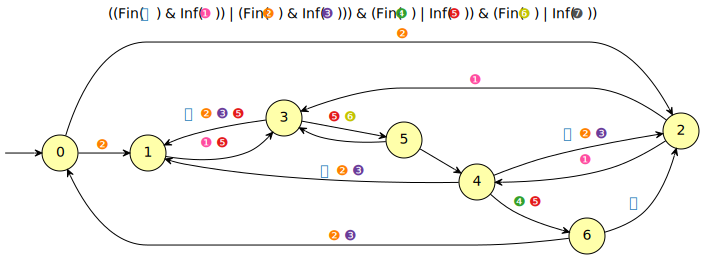

In [2]:
a = spot.automaton("""HOA: v1 name: "case5" States: 7 Start: 0 AP: 2
"a" "b" Acceptance: 8 ((Fin(0) & Inf(1)) | (Fin(2) & Inf(3))) &
(Fin(4) | Inf(5)) & (Fin(6) | Inf(7)) properties: trans-labels
explicit-labels trans-acc --BODY-- State: 0 [0&1] 1 {2} [0&1] 2 {2}
State: 1 [0&1] 3 {1 5} State: 2 [0&1] 3 {1} [0&1] 4 {1} State: 3 [0&1]
1 {0 2 3 5} [!0&!1] 5 {5 6} State: 4 [0&1] 1 {0 2 3} [0&1] 2 {0 2 3}
[!0&!1] 6 {4 5} State: 5 [0&1] 3 [0&1] 4 State: 6 [!0&1] 0 {2 3}
[!0&1] 2 {0} --END--""")
display(a)

# Crash course on Spot's Python bindings

Before we write a full algorithm, let's review some of the Spot functions available via Python that we will use.

## Acceptance conditions

An acceptance condition in Spot is a pair $(n,f)$ where $n$ is a number of acceptance sets, and $f$ is a positive Boolean formula over terms $\mathsf{Fin}(i)$ and $\mathsf{Inf}(i)$ with $0\le i< n$.

In [3]:
acc = a.acc()
print(acc)

(8, ((Fin(0) & Inf(1)) | (Fin(2) & Inf(3))) & (Fin(4) | Inf(5)) & (Fin(6) | Inf(7)))


Assuming we have found a cycle visiting acceptance sets ${1,2,3}$, we can check whether this cycle satisifies the condition as follows:

In [4]:
acc.accepting([1,2,3])

True

We can modify the acceptance condition in a couple of ways.

For instance we can `remove` terms that use some acceptance set $i$:
- If you assume that $i$ is *absent from the automaton*, then removing $i$ means replacing $\mathsf{Inf}(i)$ by $\bot$ and replacing $\mathsf{Fin}(i)$ by $\top$.
- If you assume that $i$ is *always present*, then removing $i$ means replacing $\mathsf{Inf}(i)$ by $\top$ and replacing $\mathsf{Fin}(i)$ by $\bot$.

The `remove` method does this on multiple acceptance sets at a time. Its second argument tells whether the given sets are absent (`True`) or always present (`False`).

In [5]:
print(acc.remove([1,4], True))
print(acc.remove([2], False))

(8, Fin(2) & Inf(3) & (Fin(6) | Inf(7)))
(8, Fin(0) & Inf(1) & (Fin(4) | Inf(5)) & (Fin(6) | Inf(7)))


Instead of removing missings sets, we may also restrict the acceptance to the sets that are used.
The `acc.restrict_to(sets)` method is simply a wrapper for `acc.remove(allsets-sets, True)`.

In [6]:
print(acc.restrict_to([0,2,3,6]))

(8, Fin(2) & Inf(3) & Fin(6))


The `acc.force_inf(sets)` method will replace $\mathsf{Fin}(i)$ by $\bot$ for each $i$ in `sets`.  It is similar to `acc.remove(sets, False)`, except it does not remove $\mathsf{Inf}(i)$.

In [7]:
print(acc.force_inf([0]))

(8, Fin(2) & Inf(3) & (Fin(4) | Inf(5)) & (Fin(6) | Inf(7)))


The `acc.fin_unit()` method returns the set of marks $M$ such that the formula can be seen as $\varphi' \land \bigwedge_{m\in M} \mathsf{Fin}(m)$.

In [8]:
a2 = acc.restrict_to([0,2,3,6])
print(a2, "=>", a2.fin_unit())

(8, Fin(2) & Inf(3) & Fin(6)) => {2,6}


Finally, the last operation about acceptance conditions we need in the algorithm is to iterate over the top disjuncts. The `top_disjuncts()` returns the acceptance condition itself if its formula is not a disjunction.

In [9]:
for c in acc.top_disjuncts():
    print("*", c)

* (8, ((Fin(0) & Inf(1)) | (Fin(2) & Inf(3))) & (Fin(4) | Inf(5)) & (Fin(6) | Inf(7)))


In [10]:
acc2 = spot.acc_cond('Rabin 3')
print("Rabin:", acc2)
for d in acc2.top_disjuncts():
    print("*", d)

Rabin: (6, (Fin(0) & Inf(1)) | (Fin(2) & Inf(3)) | (Fin(4) & Inf(5)))
* (6, Fin(0) & Inf(1))
* (6, Fin(2) & Inf(3))
* (6, Fin(4) & Inf(5))


## SCC decomposition

The `scc_info` object computes the list of SCCs in an automaton:

In [11]:
si = spot.scc_info(a)

def print_scc_info(si, log=""):
    n = si.scc_count()
    print(log, "Number of SCCs:", n)
    for s in range(n):
        print(log, "- SCC{}: {}{}".format(s, si.states_of(s), " trivial" if si.is_trivial(s) else ""))

print_scc_info(si)

 Number of SCCs: 1
 - SCC0: (0, 1, 3, 5, 4, 2, 6)


In this case the automaton had only one SCC.  It is possible to constrain the SCC decomposition such that transitions labeled by some specified acceptance sets are not considered as part of any cycle.   This is done by passing an `scc_and_mark_filter` object to `scc_info`.  Let's apply this to the acceptance set ⓿ and the automaton from above.

In [12]:
filt = spot.scc_and_mark_filter(a, [2])

si = spot.scc_info(filt)
print_scc_info(si)

 Number of SCCs: 3
 - SCC0: (0,) trivial
 - SCC1: (3, 5, 4, 6, 2)
 - SCC2: (1,) trivial


Displaying only one SCC is a bit of a hack at the moment, as Spot only has output for entire automata.  Let's hide this into a function.  It will only work on non-trivial SCCs, which is enough for our usage.

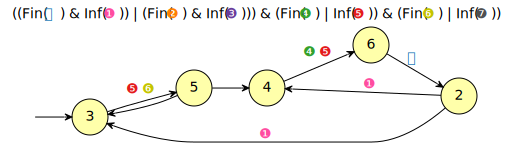

In [13]:
def display_scc(si, sccnum):
    display(si.split_on_sets(sccnum, [], True)[0])
    
display_scc(si, 1)

As the name suggest, we can use `scc_and_mark_filter` to restrict `scc_info` to some SCC (specified by an SCC number in another `scc_info`).
For instance, let's filter the above `SCC #1` on set ❹.

 Number of SCCs: 4
 - SCC0: (4,) trivial
 - SCC1: (3, 5)
 - SCC2: (2,) trivial
 - SCC3: (6,) trivial


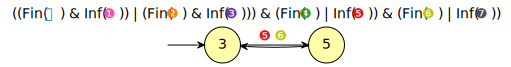

In [14]:
filt2 = spot.scc_and_mark_filter(si, 1, [4])
si2 = spot.scc_info(filt2)
print_scc_info(si2)
display_scc(si2, 1)

Finally, we can also use `scc_and_mark_filter` to temporarily override the acceptance conditon of the underlying automaton.  However, we have to be very careful, because the underlying automaton acceptance condition is actually modified by `scc_and_mark_filter`. The original acceptance will be restored only after `scc_and_mark_filter` is destroyed.

 Number of SCCs: 4
 - SCC0: (4,) trivial
 - SCC1: (3, 5)
 - SCC2: (2,) trivial
 - SCC3: (6,) trivial


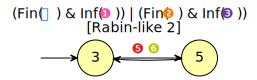

before filt2 deletion: (8, (Fin(0) & Inf(1)) | (Fin(2) & Inf(3)))
after filt2 deletion: (8, ((Fin(0) & Inf(1)) | (Fin(2) & Inf(3))) & (Fin(4) | Inf(5)) & (Fin(6) | Inf(7)))


In [15]:
acc = a.acc().restrict_to([0,1,2,3])

filt2 = spot.scc_and_mark_filter(si, 1, [4])
filt2.override_acceptance(acc)
si2 = spot.scc_info(filt2)
print_scc_info(si2)
display_scc(si2, 1)

print("before filt2 deletion:", a.acc())
del si2, filt2
print("after filt2 deletion:", a.acc())

The use-case for `override_acceptance()` is that we simplify the acceptance condition before calling a recursive function on the filtered automaton; and then we destroy the `scc_and_mark_filter` when backtracking from the recursion, restoring the original acceptance of the automaton.

For these reason, it's better to use `scc_and_mark_filter` as a [context manager](https://docs.python.org/3/reference/datamodel.html#context-managers):

 Number of SCCs: 4
 - SCC0: (4,) trivial
 - SCC1: (3, 5)
 - SCC2: (2,) trivial
 - SCC3: (6,) trivial


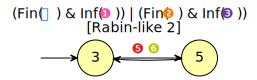

in filt2 context: (8, (Fin(0) & Inf(1)) | (Fin(2) & Inf(3)))
outside filt2 context: (8, ((Fin(0) & Inf(1)) | (Fin(2) & Inf(3))) & (Fin(4) | Inf(5)) & (Fin(6) | Inf(7)))


In [16]:
acc = a.acc().restrict_to([0,1,2,3])

with spot.scc_and_mark_filter(si, 1, [4]) as filt2:
    filt2.override_acceptance(acc)
    si2 = spot.scc_info(filt2)
    print_scc_info(si2)
    display_scc(si2, 1)
    print("in filt2 context:", a.acc())
print("outside filt2 context:", a.acc())

# Generic Emptiness Check

Using the above functions, the `is_empty1` is an implementation that most closely ressembles the algorithm in the paper:

In [17]:
def is_empty1(g):
    # By default, scc_info keep tracks of many things we do not need.
    # This is disabled with option NONE.
    si = spot.scc_info_with_options(g, spot.scc_info_options_NONE)
    for scc_num in range(si.scc_count()):
        if si.is_trivial(scc_num):
            continue
        if not is_scc_empty1(si, scc_num):
            return False
    return True

def is_scc_empty1(si, scc_num, acc=None):
    if acc is None: # if the acceptance isn't forced, get it from the automaton        
        acc = si.get_aut().acc()
    occur, common = si.acc_sets_of(scc_num), si.common_sets_of(scc_num)
    acc = acc.restrict_to(occur)
    acc = acc.remove(common, False)
    if acc.is_t(): return False
    if acc.is_f(): return True
    if acc.accepting(occur): return False
    rest = spot.acc_code.f()
    for cl in acc.top_disjuncts():
        fu = cl.fin_unit() # Is there Fin at the top level
        if fu:
            with spot.scc_and_mark_filter(si, scc_num, fu) as filt:
                filt.override_acceptance(cl.remove(fu, True))
                if not is_empty1(filt):
                    return False
        else:
            rest |= cl.get_acceptance()
    if not rest.is_f():
        rest = spot.acc_cond(acc.num_sets(), rest)
        # Pick some Fin term anywhere in the formula
        fo = rest.fin_one()
        # Try to solve assuming Fin(fo)=True
        with spot.scc_and_mark_filter(si, scc_num, [fo]) as filt:
            filt.override_acceptance(rest.remove([fo], True))
            if not is_empty1(filt):
                return False
        # Try to solve assuming Fin(fo)=False
        if not is_scc_empty1(si, scc_num, acc.force_inf([fo])):
            return False
    return True

In [18]:
is_empty1(a)

False

# Generic Emptiness Check with verbose output

This version of `is_empty1()` will log its output and display the intermediate automata so we can see how the algorithm progresses step by step.

In [19]:
def log_is_empty1(log, g):
    print(log, "is_empty() running SCC decomposition")
    # We need to pass the TRACK_STATE option for print_scc_info() to work
    si = spot.scc_info_with_options(g, spot.scc_info_options_TRACK_STATES)
    print_scc_info(si, log)
    for scc_num in range(si.scc_count()):
        if si.is_trivial(scc_num):
            continue
        if not log_is_scc_empty1("{}SCC{}:".format(log, scc_num), si, scc_num):
            return False
    return True

def log_is_scc_empty1(log, si, scc_num, acc=None):
    if acc is None:
        acc = si.get_aut().acc()
    print("{} is_scc_empty() with acceptance {} on".format(log, acc.get_acceptance()))
    display_scc(si, scc_num)
    occur, common = si.acc_sets_of(scc_num), si.common_sets_of(scc_num)
    print("{} occur={}, common={}".format(log, occur, common))
    acc = acc.restrict_to(occur)
    acc = acc.remove(common, False)
    print("{} acceptance reduced to {}".format(log, acc.get_acceptance()))
    if acc.is_t(): return False
    if acc.is_f(): return True
    if acc.accepting(occur): return False
    rest = spot.acc_code.f()
    for idx, cl in enumerate(acc.top_disjuncts()):
        print("{}clause{}: considering clause {}".format(log, idx, cl.get_acceptance()))
        fu = cl.fin_unit() # Is there Fin at the top level
        if fu:
            print("{}clause{}: unit-Fin(s) present {}".format(log, idx, fu))
            with spot.scc_and_mark_filter(si, scc_num, fu) as filt:
                filt.override_acceptance(cl.remove(fu, True))
                if not log_is_empty1("{}clause{}:Fin{}=1:".format(log, idx, fu), filt):
                    return False
        else:
            print("{}clause{}: no unit-Fin(s) present, postponing".format(log, idx))
            rest |= cl.get_acceptance()
    if not rest.is_f():
        rest = spot.acc_cond(acc.num_sets(), rest)
        # Pick some Fin term anywhere in the formula
        fo = rest.fin_one()
        print("{}rest: arbritrary Fin selected {} for {}".format(log, fo, rest.get_acceptance()))
        # Try to solve assuming Fin(fo)=True
        with spot.scc_and_mark_filter(si, scc_num, [fo]) as filt:
            filt.override_acceptance(rest.remove([fo], True))
            if not log_is_empty1("{}rest:Fin({})=1:".format(log, idx, fo), filt):
                return False
        # Try to solve assuming Fin(fo)=False
        if not log_is_scc_empty1("{}rest:Fin({})=0:".format(log, idx, fo), 
                                 si, scc_num, acc.force_inf([fo])):
            return False
    return True

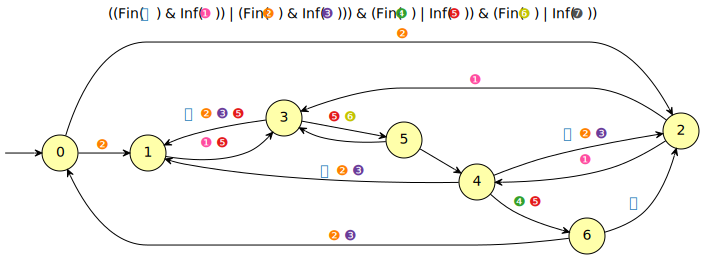

top: is_empty() running SCC decomposition
top: Number of SCCs: 1
top: - SCC0: (0, 1, 3, 5, 4, 2, 6)
top:SCC0: is_scc_empty() with acceptance ((Fin(0) & Inf(1)) | (Fin(2) & Inf(3))) & (Fin(4) | Inf(5)) & (Fin(6) | Inf(7)) on


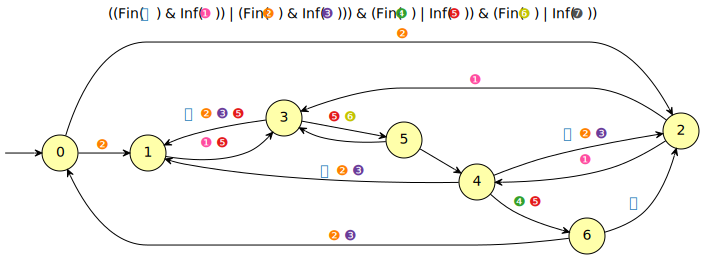

top:SCC0: occur={0,1,2,3,4,5,6}, common={}
top:SCC0: acceptance reduced to ((Fin(0) & Inf(1)) | (Fin(2) & Inf(3))) & (Fin(4) | Inf(5)) & Fin(6)
top:SCC0:clause0: considering clause ((Fin(0) & Inf(1)) | (Fin(2) & Inf(3))) & (Fin(4) | Inf(5)) & Fin(6)
top:SCC0:clause0: unit-Fin(s) present {6}
top:SCC0:clause0:Fin{6}=1: is_empty() running SCC decomposition
top:SCC0:clause0:Fin{6}=1: Number of SCCs: 3
top:SCC0:clause0:Fin{6}=1: - SCC0: (1, 3)
top:SCC0:clause0:Fin{6}=1: - SCC1: (0, 2, 4, 6)
top:SCC0:clause0:Fin{6}=1: - SCC2: (5,) trivial
top:SCC0:clause0:Fin{6}=1:SCC0: is_scc_empty() with acceptance ((Fin(0) & Inf(1)) | (Fin(2) & Inf(3))) & (Fin(4) | Inf(5)) on


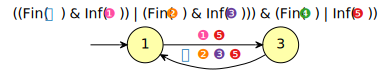

top:SCC0:clause0:Fin{6}=1:SCC0: occur={0,1,2,3,5}, common={5}
top:SCC0:clause0:Fin{6}=1:SCC0: acceptance reduced to (Fin(0) & Inf(1)) | (Fin(2) & Inf(3))
top:SCC0:clause0:Fin{6}=1:SCC0:clause0: considering clause Fin(0) & Inf(1)
top:SCC0:clause0:Fin{6}=1:SCC0:clause0: unit-Fin(s) present {0}
top:SCC0:clause0:Fin{6}=1:SCC0:clause0:Fin{0}=1: is_empty() running SCC decomposition
top:SCC0:clause0:Fin{6}=1:SCC0:clause0:Fin{0}=1: Number of SCCs: 2
top:SCC0:clause0:Fin{6}=1:SCC0:clause0:Fin{0}=1: - SCC0: (3,) trivial
top:SCC0:clause0:Fin{6}=1:SCC0:clause0:Fin{0}=1: - SCC1: (1,) trivial
top:SCC0:clause0:Fin{6}=1:SCC0:clause1: considering clause Fin(2) & Inf(3)
top:SCC0:clause0:Fin{6}=1:SCC0:clause1: unit-Fin(s) present {2}
top:SCC0:clause0:Fin{6}=1:SCC0:clause1:Fin{2}=1: is_empty() running SCC decomposition
top:SCC0:clause0:Fin{6}=1:SCC0:clause1:Fin{2}=1: Number of SCCs: 2
top:SCC0:clause0:Fin{6}=1:SCC0:clause1:Fin{2}=1: - SCC0: (3,) trivial
top:SCC0:clause0:Fin{6}=1:SCC0:clause1:Fin{2}=1: - S

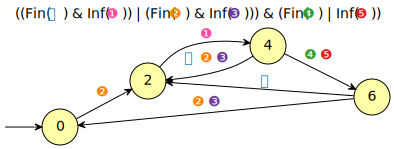

top:SCC0:clause0:Fin{6}=1:SCC1: occur={0,1,2,3,4,5}, common={}
top:SCC0:clause0:Fin{6}=1:SCC1: acceptance reduced to ((Fin(0) & Inf(1)) | (Fin(2) & Inf(3))) & (Fin(4) | Inf(5))
top:SCC0:clause0:Fin{6}=1:SCC1:clause0: considering clause ((Fin(0) & Inf(1)) | (Fin(2) & Inf(3))) & (Fin(4) | Inf(5))
top:SCC0:clause0:Fin{6}=1:SCC1:clause0: no unit-Fin(s) present, postponing
top:SCC0:clause0:Fin{6}=1:SCC1:rest: arbritrary Fin selected 0 for ((Fin(0) & Inf(1)) | (Fin(2) & Inf(3))) & (Fin(4) | Inf(5))
top:SCC0:clause0:Fin{6}=1:SCC1:rest:Fin(0)=1: is_empty() running SCC decomposition
top:SCC0:clause0:Fin{6}=1:SCC1:rest:Fin(0)=1: Number of SCCs: 1
top:SCC0:clause0:Fin{6}=1:SCC1:rest:Fin(0)=1: - SCC0: (0, 2, 4, 6)
top:SCC0:clause0:Fin{6}=1:SCC1:rest:Fin(0)=1:SCC0: is_scc_empty() with acceptance (Inf(1) | (Fin(2) & Inf(3))) & (Fin(4) | Inf(5)) on


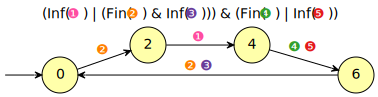

top:SCC0:clause0:Fin{6}=1:SCC1:rest:Fin(0)=1:SCC0: occur={1,2,3,4,5}, common={}
top:SCC0:clause0:Fin{6}=1:SCC1:rest:Fin(0)=1:SCC0: acceptance reduced to (Inf(1) | (Fin(2) & Inf(3))) & (Fin(4) | Inf(5))


False

In [20]:
display(a)
log_is_empty1("top:", a)

# Improved version

The following `is_empty2` version more closely ressemble the version that is implemented in C++ in Spot.  It's based on a few features of `scc_info` that haven't been discussed so far:
1. `scc_info` can detect some accepting or rejecting components during the discovery of the SCCs: this happens for instance if a cycle visits a set of acceptance marks that satisfies the acceptance, or if the sets common to the whole SCC violate the acceptance condition (this is exactly what the three `if acc. ...` tests are doing at the top of `is_scc_empty1()` are doing, so these can be removed).  The acceptance or rejectance of an SCC can be tested with `is_accepting_scc()` or `is_rejecting_scc()`.  Note that for these two method, a result of `False` should be understood as "unknown".  Deciding those unknown cases is precisely the purpose of `is_scc_empty()`.
2. `scc_info` can be configured to abort the construction as soon as an accepting SCC is found by passing the `STOP_ON_ACC` options.  If such an early abort occurs, the `one_accepting_scc()` method returns the SCC number of the accepting SCC.  Otherwise it returns `-1`.

Additionally, the algorithm starts with passing the result of `acc().fin_unit()` to the `scc_and_mark_filter` object. This initial call to `fin_unit()` can detect such cases alreade for the initial SCC decomposition without waiting for a recursive call.

In [21]:
def is_empty2(g):
    return is_empty2_rec(spot.scc_and_mark_filter(g, g.acc().fin_unit()))

def is_empty2_rec(g):
    si = spot.scc_info_with_options(g, spot.scc_info_options_STOP_ON_ACC)
    if si.one_accepting_scc() >= 0:
        return False
    for scc_num in range(si.scc_count()):
        if si.is_rejecting_scc(scc_num): # this includes trivial SCCs
            continue
        if not is_scc_empty2(si, scc_num):
            return False
    return True

def is_scc_empty2(si, scc_num, acc=None):
    if acc is None: # acceptance isn't forced, get it from the automaton        
        acc = si.get_aut().acc()
    occur, common = si.acc_sets_of(scc_num), si.common_sets_of(scc_num)
    acc = acc.restrict_to(occur)
    acc = acc.remove(common, False)
    # 3 stop conditions removed here, because they are caught by 
    # one_accepting_scc() or is_rejecting_scc() in is_empty2()
    rest = spot.acc_code.f()
    for cl in acc.top_disjuncts():
        fu = cl.fin_unit() # Is there Fin at the top level
        if fu:
            with spot.scc_and_mark_filter(si, scc_num, fu) as filt:
                filt.override_acceptance(cl.remove(fu, True))
                if not is_empty2_rec(filt):
                    return False
        else:
            rest |= cl.get_acceptance()
    if not rest.is_f():
        rest = spot.acc_cond(acc.num_sets(), rest)
        # Pick some Fin term anywhere in the formula
        fo = rest.fin_one()
        # Try to solve assuming Fin(fo)=True
        with spot.scc_and_mark_filter(si, scc_num, [fo]) as filt:
            filt.override_acceptance(cl.remove([fo], True))
            if not is_empty2_rec(filt):
                return False
        # Try to solve assuming Fin(fo)=False
        if not is_scc_empty2(si, scc_num, acc.force_inf([fo])):
            return False
    return True

In [22]:
is_empty2(a)

False

# Current C++ implementation

The current C++ implementation of the generic emptiness check closely ressemble `is_empty2()`.  It was introduced in a slightly different form in Spot 2.7, and in the current form in Spot 2.9.  The version in Spot 2.7 and 2.8 correspond to our ATVA'19 paper.  The above version has improved handling for the disjuncts without Fin-units, which are all gathered into a common `rest` variable.  

This C++ implementation is automatically called from Python by the `is_empty()` method of automata when their acceptance condition contain `Fin` acceptance.  (If there is no Fin acceptance, a simpler algorithm is used.)

In [23]:
a.is_empty()

False

Since Spot 2.8 it is also possible to extract an accepting run in the form of a lasso-shaped run:

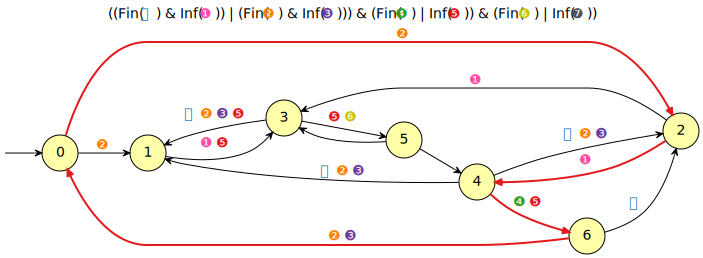

In [24]:
a.accepting_run().highlight(5)
display(a)

# Former C++ implementation

Before version 2.7, Spot checked the emptiness of an automaton with $\mathsf{Fin}$ in the acceptance formula by transforming the automaton into an automaton with $\mathsf{Fin}$-less acceptance.  The procedure that performs this transformation is called `remove_fin()`.  Then `is_empty()` would be called on the result, but for Fin-less automata this is easily solved (on Fin-less automata even `is_empty2()` would never need to call `is_scc_empty2()`) .

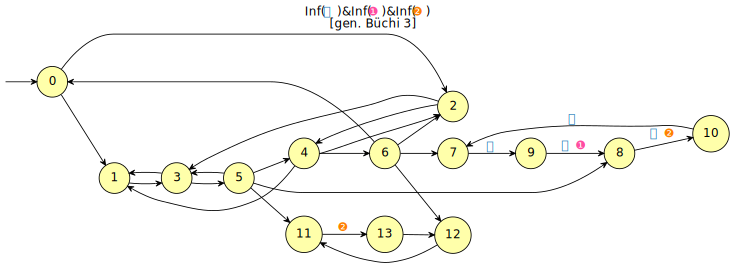

False


In [25]:
a_finless = spot.remove_fin(a)
display(a_finless)
print(a_finless.is_empty())

What the above output hides, is that `remove_fin()` actually builds a larger automaton, then it removes all the states that cannot reach any cycle, and also it cleanup the acceptance conditions so that it only used the acceptance marks that occur in what remains.  Here we only see the end result of that process.

Let's encapsulate this old approach into a function for benchmarking.

In [26]:
def old_is_empty(g):
    return spot.remove_fin(g).is_empty()

# Comparison of the three approaches

We compare these four implementations:
- `is_empty1()`: Python implementation closest to the Algorithm in the paper
- `is_empty2()`: improved Python implementation closest to the C++ algorithm actually implemented
- `is_empty()`: the current C++ implementation
- `old_is_empty()`: the remove_fin()-based implementation (considered as C++ because `old_is_empty()` justs consists in two C++ calls)

The `is_empty()` implementation in fact support three variants, which we call as follows:
- `is_empty_spot29()` the default implementation, which is a C++ version the `is_empty2()` Python function
- `is_empty_atva19()` a C++ implementation corresponding to the ATVA'19 paper, that differ from the previous version in the handling of disjunct without unit-Fin.  This is actually the implementation in Spot 2.8.7
- `is_empty_spot28()` the C++ implementation that was in Spot 2.7, and up to Spot 2.8.6, and that was used to build the benchmark in our ATVA'19 paper.  It actually contains one typo that do not make the result incorrect, but that may lead to extra recursive calls.  We measure this version so we can verify whether is typo is actually bad or not (it's not).

A benchmark consist of a list of automata, and a repetition factor N.  For each algorithm, we mesure the time it takes to process one automaton N times. We repeat this measurement three times (`TRIES` variable) and keep the best value.  These best values are then displayed in a table where each line correspond to an automaton, and each column to an algorithm.  Additionally, some extra column display the result of the check (`FFFF` if all algorithms return `False`, and `TTTT` if all of them return `True`), and the acceptance condition of the automaton.

An aditional line at the bottom compute the [geometric mean](https://en.wikipedia.org/wiki/Geometric_mean) and arithmetic means of those runtimes.  (Using an arithmetic mean is biaised towards large graphs.)

The code below is used to run a benchmark and show the results.  Further sections discuss different benchmarks sets.

In [27]:
import pandas as pd
from timeit import Timer
from time import monotonic
from scipy.stats.mstats import gmean
from math import isnan
import lzma

In [28]:
def check_res(v):
    """If some emptiness checks disagree, color the case in red."""
    return '' if v in ('FFFF', 'TTTT') or (type(v) is float and isnan(v)) else 'background-color: red'

def my_highlight_min(data):
    """highlight the minimum of a row, and also highlight values that are not far away."""
    m = data.min()
    is_min = data == m
    is_good = (data <= (m*1.05)) | (data <= m+0.005)
    return ['background-color: #00ff7f' if m else
            'background-color: #b3ffd9' if g else ''
            for m,g in zip(is_min, is_good)]

def my_highlight_max(data):
    """highlight the maximum of a row, and also highlight values that are not far away."""
    m = data.max()
    is_max = data == m
    is_good = (data >= (m/1.05)) | (data >= m-0.005)
    return ['background-color: #ff5050' if m else
            'background-color: #ff9999' if g else ''
            for m,g in zip(is_max, is_good)]

TRIES=3

def mytime(callable):
    """Measure TRIES times the time it take to run CALLABLE, and return the best of the TRIES measures in milliseconds."""
    t = Timer(callable)
    # autorange will find a suitable COUNT number such that running CALLABLE COUNT times takes at least 0.2 seconds.
    # The time it took to run CALLABLE COUNT times is TIME.
    count, time = t.autorange()
    # If we where asked to do multiple tries, we simply reuse COUNT, and keep track of the best time.
    # autorange did the first try, we need TRIES-1 more.
    for _ in range(1, TRIES):
        time = min(time, t.timeit(count))
    return time*1000/count

def non_triv_sccs(si):
    """Count the number of non-trivial SCCs"""
    c = si.scc_count()
    return c - sum(si.is_trivial(s) for s in range(c))

def non_rej_sccs(si):
    """Count the number of non-"obviously rejecting" (this include trivial) SCCs"""
    c = si.scc_count()
    return c - sum(si.is_rejecting_scc(s) for s in range(c))

def non_rej_states(si):
    """Count total the number of states in non-obviously-rejecting SCCs"""
    return sum(len(si.states_of(s)) for s in range(si.scc_count()) if not si.is_rejecting_scc(s))

def run_bench(automata):
    ge1 = []
    ge2 = []
    ge3a = []
    ge3b = []
    ge3c = []
    ge4 = []
    emp = []
    acc = []
    states = []
    edges = []
    sets = []
    sccs = []
    ntsccs = []
    nrsccs = []
    nrstates = []
    
    start = monotonic()
    for num, aut in enumerate(automata):
        print(num, end='...')
        res4 = old_is_empty(aut)
        spot.generic_emptiness_check_select_version("spot28")
        res3a = aut.is_empty()
        spot.generic_emptiness_check_select_version("atva19")
        res3b = aut.is_empty()
        spot.generic_emptiness_check_select_version("spot29")
        res3c = aut.is_empty()
        res2 = is_empty2(aut)
        res1 = is_empty1(aut)
        time4 = mytime(lambda: old_is_empty(aut))
        spot.generic_emptiness_check_select_version("spot28")
        time3a = mytime(lambda: aut.is_empty())
        spot.generic_emptiness_check_select_version("atva19")
        time3b = mytime(lambda: aut.is_empty())
        spot.generic_emptiness_check_select_version("spot29")
        time3c = mytime(lambda: aut.is_empty())
        time2 = mytime(lambda: is_empty2(aut))
        time1 = mytime(lambda: is_empty1(aut))
        ge1.append(time1)
        ge2.append(time2)
        ge3a.append(time3a)
        ge3b.append(time3b)
        ge3c.append(time3c)
        ge4.append(time4)
        emp.append(str(res1)[0] + str(res2)[0] + str(res3a)[0] + str(res3b)[0] + str(res3c)[0] + str(res4)[0])
        acc.append(str(aut.get_acceptance()))
        states.append(aut.num_states())
        edges.append(aut.num_edges())
        sets.append(aut.num_sets())
        si = spot.scc_info_with_options(aut, spot.scc_info_options_TRACK_STATES)
        sccs.append(si.scc_count())
        ntsccs.append(non_triv_sccs(si))
        nrsccs.append(non_rej_sccs(si))
        nrstates.append(non_rej_states(si))
    res = pd.DataFrame({'Python/is_empty1': ge1,
                        'Python/is_empty2': ge2,
                        'C++/is_empty_spot29': ge3c,
                        'C++/is_empty_atva19': ge3b,
                        'C++/is_empty_spot28': ge3a,
                        'C++/old_is_empty': ge4,
                        '/result': emp,
                        'aut/states': states,
                        'aut/edges': edges,
                        'aut/sccs': sccs,
                        'aut/ntsccs': ntsccs,
                        'aut/nrsccs': nrsccs,
                        'aut/nrstates': nrstates,
                        'aut/sets': sets,
                        'aut/acc': acc})
    print("\nrun_bench() took {:.2f} seconds".format(monotonic() - start))
    return res

def to_tuples(cols):
    res = []
    for i in cols:
        res.append(tuple(i.split('/')))
    return res

def all_emptiness(cols):
    return [i for i in cols if i[0] in ('C++', 'Python')]


def show_bench(res):
    tmp = res.copy()
    tmp.columns=pd.MultiIndex.from_tuples(to_tuples(tmp.columns))
    allec=all_emptiness(tmp.columns)
    gm = tmp.loc[:,allec].apply(gmean)  # Geometric mean
    am = tmp.loc[:,allec].mean() # Arithmetic mean    
    tmp.loc['gm'], tmp.loc['am'] = gm, am
    return tmp.style\
            .set_table_styles([{'selector': 'th.col_heading.level0', 
                                'props': [('text-align', 'center'), ('border-bottom', '1px solid'),
                                          ('border-left', '1ex solid white'), ('border-right', '1ex solid white') ]}])\
            .set_properties(subset=pd.IndexSlice['gm':'am', :], **{'background-color': 'LightGrey'}) \
            .apply(my_highlight_max, axis=1, subset=allec)\
            .apply(my_highlight_min, axis=1, subset=allec)\
            .applymap(check_res, subset=to_tuples(['/result']))

def save_bench(auts, filename):
    with lzma.open(filename + ".xz", 'wt') as file:
        for aut in auts:
            file.write(aut.to_str('hoa'))
            file.write('\n')

def lazy_load_bench(filename):
    return spot.automata("xz -d -c {}.xz |".format(filename))

def load_bench(filename):
    return list(lazy_load_bench(filename))

## Benchmark 1: Twelve small automata that are part of Spot's test suite

In [29]:
twelve = list(spot.automata('''
HOA: v1  name: "aut"  States: 4  Start: 0  AP: 0
Acceptance: 4 Fin(0) & (Inf(1) | (Fin(2) & Inf(3)))
--BODY--
State: 0  [t] 0 {0}  [t] 1 {0 2}
State: 1  [t] 2
State: 2  [t] 1      [t] 0 {0}    [t] 3 {3}
State: 3  [t] 2 {1}  [t] 0
--END--
HOA: v1 States: 7 Start: 0 AP: 3 "a" "b" "c" Acceptance: 3 Fin(0) & Fin(2)
& Inf(1) properties: trans-labels explicit-labels trans-acc --BODY--
State: 0 [2] 1 [!0&!2] 2 [0&!2] 3 [0&!2] 4 State: 1 [!0 | 1] 1 {1 2}
[0&!1] 5 {1} State: 2 [t] 2 {0} State: 3 [!0&!2] 2 [0&!2] 3 State: 4
[0&!1&2] 1 [!0&2 | 1&2] 1 {2} [!0&!2] 6 {2} [0&!1&!2] 4 [0&1&!2] 4 {2}
State: 5 [!0 | 1] 1 {2} [0&!1] 5 State: 6 [0&!1] 6 {0} [!0 | 1] 6 {0
2} --END--
HOA: v1 States: 11 Start: 0 AP: 3 "a" "b" "c" Acceptance: 5 (Fin(0)
| Inf(1)) & (Fin(2) | Inf(3)) & Fin(4) properties: trans-labels
explicit-labels trans-acc --BODY-- State: 0 [0&!1&!2] 1 {1} [0&!1&!2]
2 {1} [!0&!2] 3 {1} [0&1&!2] 4 {1} [0&1&!2] 5 {1} [0&!1&2] 6 {1} [!0&2 |
1&2] 7 {1} State: 1 [0&!1&!2] 1 {0 2} [!0&!2] 3 {0 2} [0&1&!2] 4 {0 2}
State: 2 [0&!1&!2] 2 {0 2} [!0&!2] 8 {0 2 4} [0&1&!2] 5 {0 2 4} [0&!1&2]
6 {0 2} [!0&2 | 1&2] 7 {0 2 4} State: 3 [0&!1] 9 {1 2} [!0 | 1] 3 {1 2}
State: 4 [0&!1&!2] 1 {1 2} [!0&!2] 3 {1 2} [0&1&!2] 4 {1 2} State: 5
[0&!1&!2] 2 {1 2} [!0&!2] 8 {1 2 4} [0&1&!2] 5 {1 2 4} [0&!1&2] 6 {1 2}
[!0&2 | 1&2] 7 {1 2 4} State: 6 [0&!1] 6 {0 3} [!0 | 1] 7 {0 3 4} State:
7 [0&!1] 6 {1 3} [!0 | 1] 7 {1 3 4} State: 8 [0&!1] 10 {1 2} [!0 | 1]
8 {1 2 4} State: 9 [0&!1] 9 {0 2} [!0 | 1] 3 {0 2} State: 10 [0&!1]
10 {0 2} [!0 | 1] 8 {0 2 4} --END--
HOA: v1 States: 8 Start: 0 AP: 3 "a" "b" "c" Acceptance: 6 ((Fin(0) &
Inf(1)) | (Fin(2) & Inf(3))) & Fin(4) & Inf(5) properties: trans-labels
explicit-labels state-acc complete properties: deterministic --BODY--
State: 0 {2 4} [0&2] 1 [!0&2] 2 [!0&!1&!2] 3 [!0&1&!2] 4 [0&!2] 5 State:
1 {1 2 4} [!0] 6 [0] 1 State: 2 {1 2 5} [!0] 6 [0] 1 State: 3 {1 2 4}
[t] 3 State: 4 {1 2 4} [!0&2] 6 [0&2] 1 [!1&!2] 3 [0&1&!2] 4 [!0&1&!2]
7 State: 5 {1 2 4} [!0&2] 6 [0&2] 1 [!0&!1&!2] 3 [0&!2] 5 [!0&1&!2]
7 State: 6 {2 5} [!0] 6 [0] 1 State: 7 {3 4} [!0&2] 6 [0&2] 1 [!1&!2]
3 [0&1&!2] 4 [!0&1&!2] 7 --END--
HOA: v1 States: 10 Start: 0 AP: 2 "a" "b" Acceptance: 5 ((Inf(4)
| Fin(0)) & Fin(1)) | (Inf(2)&Inf(3)) properties: trans-labels
explicit-labels trans-acc --BODY-- State: 0 [0&!1] 2 State: 1 [!0&!1]
9 {3} [!0&1] 7 {0 1 2} State: 2 [!0&1] 1 [0&!1] 3 {1 2} [!0&1] 2 {3}
[0&!1] 5 {1 4} State: 3 [0&!1] 5 {0 3} [!0&!1] 9 [!0&!1] 2 [0&!1] 4 State:
4 [0&!1] 3 [!0&!1] 6 {0 1 2} State: 5 [!0&!1] 7 {0} [0&!1] 4 [0&!1] 1
[0&!1] 8 {0} State: 6 [!0&!1] 5 {2} [0&!1] 4 {3} State: 7 [!0&1] 5 [0&!1]
2 {2} [!0&1] 4 State: 8 [0&!1] 1 {1} [!0&!1] 6 {0} State: 9 [0&1] 0 {1}
[0&1] 3 {2} [0&1] 7 {1} [0&!1] 8 {2 3 4} --END--
HOA: v1 States: 10 Start: 0 AP: 2 "a" "b" Acceptance: 5 (Inf(1) | (Fin(0)
& Inf(4)) | Fin(2)) & Fin(3) properties: trans-labels explicit-labels
trans-acc --BODY-- State: 0 [0&1] 9 {3} [!0&!1] 0 [0&!1] 5 {0 1} State:
1 [0&!1] 9 {4} [0&1] 8 {3} State: 2 [!0&!1] 8 {0} [!0&1] 6 {2 4} [0&1]
2 [!0&1] 7 State: 3 [0&!1] 2 {0 4} [!0&!1] 3 {1} [!0&1] 4 {0} State: 4
[0&!1] 5 {2} [0&1] 0 [!0&1] 1 {0} State: 5 [!0&!1] 0 [!0&!1] 6 State: 6
[0&1] 3 {2} [!0&1] 1 [0&1] 2 {0 1 3 4} State: 7 [0&1] 1 [!0&1] 7 {0 2}
State: 8 [!0&1] 7 [!0&!1] 9 {0} State: 9 [0&1] 8 {0} [0&!1] 5 [0&!1]
1 --END--
HOA: v1 States: 10 Start: 0 AP: 2 "a" "b" acc-name: Rabin 3 Acceptance:
6 (Fin(0) & Inf(1)) | (Fin(2) & Inf(3)) | (Fin(4) & Inf(5)) properties:
trans-labels explicit-labels trans-acc --BODY-- State: 0 [0&!1] 8 {0}
[!0&!1] 6 {0 1} State: 1 [!0&1] 4 {2} [0&1] 8 {2} State: 2 [0&1] 6 {1 4}
[!0&!1] 3 {1 4} State: 3 [!0&!1] 8 {2 4} [0&1] 4 State: 4 [!0&!1] 8 {4}
[!0&!1] 7 State: 5 [!0&!1] 2 {0 5} [!0&!1] 8 {0 4} [!0&!1] 9 {4} State:
6 [!0&1] 1 {2 3 4} State: 7 [0&!1] 5 {0} [0&!1] 7 State: 8 [!0&1] 4 {0 2}
State: 9 [0&1] 3 {4} [!0&1] 5 {4} --END--
HOA: v1 States: 10 Start: 0 AP: 2 "a" "b" Acceptance: 6 Fin(5) &
((Fin(1) & (Inf(3) | Inf(4))) | Fin(0) | Fin(2)) properties: trans-labels
explicit-labels trans-acc --BODY-- State: 0 [0&1] 8 {0} [0&!1] 6 {2}
State: 1 [!0&1] 9 {0 4 5} State: 2 [!0&1] 1 State: 3 [0&!1] 3 {2}
[0&1] 4 {3 5} State: 4 [0&1] 7 {5} [0&!1] 9 {2} [!0&1] 0 {0 2} State:
5 [!0&1] 1 [!0&1] 3 {2 3} State: 6 [0&!1] 8 {1 2 5} [!0&1] 7 {3} State:
7 [0&1] 2 {0} [!0&1] 5 State: 8 [0&!1] 3 {4 5} State: 9 [!0&1] 3 {1 2}
[0&1] 1 {4} [0&!1] 5 {2} --END--
HOA: v1 States: 10 Start: 0 AP: 2 "a" "b" acc-name: Streett 3 Acceptance:
6 (Fin(0) | Inf(1)) & (Fin(2) | Inf(3)) & (Fin(4) | Inf(5)) properties:
trans-labels explicit-labels trans-acc deterministic --BODY-- State: 0
[0&1] 1 [0&!1] 9 {0 5} State: 1 [0&!1] 5 State: 2 [!0&!1] 4 {1} State: 3
[!0&!1] 8 {0} State: 4 [0&1] 6 {0 3} State: 5 [!0&!1] 7 State: 6 [!0&1]
4 State: 7 [!0&!1] 3 {2 5} State: 8 [0&!1] 1 {2} [!0&!1] 2 {2} State:
9 [!0&1] 6 {2 4} --END--
HOA: v1 States: 2 Acceptance: 4 (Fin(0)|Fin(1))&(Fin(2)|Fin(3)) Start: 0
AP: 0 --BODY-- State: 0 [t] 0 {0 2 3} [t] 1 {1} State: 1 [t] 0 {2}
[t] 1 {3 0 1} --END--
HOA: v1 States: 2 Acceptance: 6 (Fin(0)|Fin(1))&(Fin(2)|Fin(3))&
(Fin(4)|Fin(5)) Start: 0 AP: 0 --BODY-- State: 0 [t] 0 {0 2 3} [t]
1 {1 4} State: 1 [t] 0 {2 5} [t] 1 {3 0 1} --END--
HOA: v1 States: 2 Start: 0 AP: 2 "a"
"b" Acceptance: 8 Fin(5) & (Inf(4) | (Fin(3) & (Inf(2) | (Fin(1) &
Inf(0))))) & (Inf(6) | Inf(7)) & (Fin(6)|Fin(7)) properties: trans-labels
explicit-labels trans-acc complete properties: deterministic --BODY--
State: 0 [0&1] 0 {4 6 7} [0&!1] 1 {0 6} [!0&1] 0 {3 7} [!0&!1] 0 {0}
State: 1 [0&1] 0 {4 6 7} [0&!1] 1 {3 6} [!0&1] 0 {4 7} [!0&!1] 1 {0}
--END--'''))

In [30]:
b1 = run_bench(twelve)

0...1...2...3...4...5...6...7...8...9...10...11...
run_bench() took 87.87 seconds


In [31]:
show_bench(b1)

Comments: The above automata are really small, and quickly solved with any method.  They were great to develop the algorithms, because they are small enough to follow the algorithm by hand, but they are nearly worthless as benchmark.

## Benchmark 2: random 100000-state automata with random acceptance

Below is a larger experiment with random acceptance conditions over 50 automata using 100000 states and 20 acceptance sets.

In [32]:
try:
    auts_b2 = load_bench("b2.hoa")
except:
    # Only compute the automata if we cannot read them from disk.
    auts_b2 = list(spot.automata('randaut -n50 -Q100000 -e.0000019 -A"random 20" 0|'))
    save_bench(auts_b2, "b2.hoa")

In [33]:
b2 = run_bench(auts_b2)

0...1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...16...17...18...19...20...21...22...23...24...25...26...27...28...29...30...31...32...33...34...35...36...37...38...39...40...41...42...43...44...45...46...47...48...49...
run_bench() took 524.69 seconds


In [34]:
show_bench(b2)

On non-empty automata, `old_is_empty()` is expected to be bad, because it has to perform `remove_fin()` on the entire automaton before starting to check it.

In [35]:
del auts_b2

## Benchmark 2 bis: random acceptance with repetition

This is a variant over the previous benchmark where we allow the acceptance condition to use an acceptance mark multiple times.

In [36]:
try:
    auts_b2b = load_bench("b2b.hoa")
except:
    auts_b2b = list(spot.automata('randaut -n50 -Q100000 -e.0000019 -A"random 20 .5" 0|'))
    save_bench(auts_b2b, "b2b.hoa")

In [37]:
b2b = run_bench(auts_b2b)

0...1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...16...17...18...19...20...21...22...23...24...25...26...27...28...29...30...31...32...33...34...35...36...37...38...39...40...41...42...43...44...45...46...47...48...49...
run_bench() took 381.31 seconds


In [38]:
show_bench(b2b)

The automaton on line 6 is quite amusing, because its acceptance condition can be reduced to false.  The `old_is_empty()` function benefits from this, because the first step of the `remove_fin()` procedure is to convert the acceptance condition into disjunctive normal form.  This conversion is done using BDD (mapping `Inf(i)` to $v_i$ and `Fin(i)` to $\lnot v_i$, and in this case the formula is easily seen to be false.  As a consequence, `remove_fin()` can return an empty automaton, and that is very easy to check. 

In [39]:
a6 = auts_b2b[6].acc().get_acceptance()
print("BEFORE:", a6)
print("AFTER:", a6.to_dnf())

BEFORE: (((((Inf(0)&Inf(5)) | Fin(15) | Inf(7)) & (Inf(9) | (Fin(16) & Fin(7) & Fin(18)))) | Inf(5) | (Fin(0)|Fin(19)) | (Fin(10) & Fin(3)) | Inf(17) | Inf(1) | Inf(17)) & Fin(14) & Inf(14)) | ((Inf(8)&Inf(13)) & Fin(7) & Fin(19) & ((Inf(2) & Fin(9)) | (Fin(16) & Fin(0) & Fin(4) & Fin(0)) | Inf(15)) & (Inf(11) | Inf(6)) & Fin(8) & (Inf(12) | Fin(7)))
AFTER: f


In [40]:
del auts_b2b

## Benchmark 3: Random 10000-state automata with Rabin acceptance (mostly empty)

Rabin automata are mostly handled via the `top_disjunct()` loop in the generic emptiness checks.  
Also they are an easy case for `remove_fin()` because they are already in disjunctive normal form.

Actually, during the development version of the generic emptiness check, the `remove_fin()` approach (called `old_is_empty()` in the table) was initially faster on Rabin automata because `scc_info` (called once in `remove_fin()`, but multiple time in all the generic emptiness checks) used to do lot of unecessary bookkeeping.  This unecessary bookkeeping is disabled with `spot.scc_info_options_NONE` or `spot.scc_info_options_STOP_ON_ACC` in the above code.

In [41]:
try:
    auts_b3 = load_bench("b3.hoa")
except:
    auts_b3 = list(spot.automata('randaut -n50 -Q10000 -e.000004 -A"Rabin 16" 0|'))
    save_bench(auts_b3, "b3.hoa")

In [42]:
b3 = run_bench(auts_b3)

0...1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...16...17...18...19...20...21...22...23...24...25...26...27...28...29...30...31...32...33...34...35...36...37...38...39...40...41...42...43...44...45...46...47...48...49...
run_bench() took 419.68 seconds


In [43]:
show_bench(b3)

We can see that running `old_is_empty()` is slightly slower than `is_empty()` on empty automata.  This can be attributed to the creation of the intermediate $\mathsf{Fin}$-less automata.  Otherwise, the work needed to explore the $\mathsf{Fin}$-less automaton is expected to be equal to the work needed by `is_empty()` to explore the original automaton recursively. This is due to the fact that the for loop triggers an exploration for each Rabin-pair that touches an SCC in the same way that `remove_fin()` will clone each SCC for each Rabin pair that intersects the SCC.

In [44]:
del auts_b3

## Benchmark 4: Streett acceptance (empty)

Let's try a similar run with Streett acceptance.

We have found quite hard to generate random Streett automata that are empty, so we build those by making the product $A_\varphi\otimes A_{\lnot\varphi}$ of two complementary Streett automata generated by `ltl2dstar`. We use `-T30` to limit the execution of the product generation (running both instances of `ltl2dstar` and `autfilt`) to 30 seconds, and `--errors=ignore` to skip cases where `autfilt --product` fails because too many acceptance sets are used (Spot is limited to 32 sets) and look for products with more than 1000 states.

Additionally, to test some non-empty automata, we also keep the positive $A_\varphi$ for each of those products.

In [45]:
try:
    auts_b4 = load_bench('b4.hoa')
except:
    auts_b4 = list(spot.automata("""
randltl -n-1 --tree-size=20..30 p0 p1 | 
ltldo --errors=ignore -T30 '(ltl2dstar -H --automata=streett %[MW]L -; 
       ltlfilt --lbt --negate -f %[MW]f | ltl2dstar -H --automata=streett - -) |
autfilt --product=- - --name="product %f" >%O' |
autfilt --acc-sets=2.. --states=1000.. -n50 |"""))
    pos = []
    for a in auts_b4:
        n = a.get_name()[8:]
        pos.append(spot.automaton("ltldo 'ltl2dstar --automata=streett' -f {} --name={}|".format(n, n)))
    auts_b4 += pos;
    save_bench(auts_b4, 'b4.hoa')

Here are the positive formula for each product we generated. This formula is saved as the name of the automaton in `b4.hoa`.

In [46]:
def info_aut(automata):
    for idx, aut in enumerate(automata):
        print('{:>3} {}'.format(idx, aut.get_name()))
info_aut(auts_b4)

  0 product 'G(((p1) M (F(p1))) U (F(((G(p1)) U (!(p1))) R (((X((0))) | ((p1) M (1))) W ((G(p1)) U (X(p0)))))))'
  1 product 'F(((G(p1)) R (F(X(p0)))) M ((p1) xor (!((G(p0)) R (p0)))))'
  2 product 'G(((p0) M (X((G(p0)) M (G(p1))))) -> ((G((F(p0)) U ((G(p1)) U (p0)))) W (p0)))'
  3 product '(F((G(!((G(p0)) <-> ((p1) & (F(p0)))))) <-> (F(X(((0) R (p1)) M (1)))))) W (0)'
  4 product '(X((0) R (p1))) R (X((p1) | (((p0) M ((1) U (p1))) W ((p0) <-> (G(p1))))))'
  5 product '(G(!(F(G(X(!(((G(p1)) W (F(p1))) xor (X(((p1) M (p0)) xor (G((p0) <-> (p1)))))))))))) -> (X(!((p1) | (G(p1)))))'
  6 product '(X(F((p1) & (G(X(p0)))))) U (G((F((G(p0)) W (G(p1)))) R (p0)))'
  7 product '(G(X(p1))) xor (!(((G((1) U (p0))) W (F(G(X((p0) xor (!(X(F(p1))))))))) R (p1)))'
  8 product 'F((p0) <-> (X((F(X(p0))) xor ((1) U (!((p1) U (F(p1))))))))'
  9 product '(F((X(p1)) -> ((G(X((0)))) U (X(p0))))) U ((X(G((p1) U (X(X(p1)))))) R (!((!(p1)) R (p0))))'
 10 product 'G((!(G((p0) xor ((!(F(G((p0) R (G(p1)))))) -> (X

In [47]:
b4 = run_bench(auts_b4)

0...1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...16...17...18...19...20...21...22...23...24...25...26...27...28...29...30...31...32...33...34...35...36...37...38...39...40...41...42...43...44...45...46...47...48...49...50...51...52...53...54...55...56...57...58...59...60...61...62...63...64...65...66...67...68...69...70...71...72...73...74...75...76...77...78...79...80...81...82...83...84...85...86...87...88...89...90...91...92...93...94...95...96...97...98...99...
run_bench() took 736.75 seconds


In [48]:
show_bench(b4)

In [49]:
del auts_b4

## Benchmark 5: Parity-like acceptance

We use a trick similar to the above to generate empty automata with a kind of parity acceptance. It is not exactly parity, but rather the conjunction of two parity acceptance (one for the positive formula, one for the negated formula).  We use `ltl2tgba -p -D` to generate parity acceptance via determinisation, and disable the main optimisations (`--low -x gf-guarantee=0`) that would result in automata with simpler acceptance conditions.

Again, to test some non-empty automata, we also keep the larger from $A_\varphi$ and $A_{\lnot\varphi}$ for each of those products.

In [50]:
try:
    auts_b5 = load_bench('b5.hoa')
except:
    auts_b5 = list(spot.automata("""
randltl -n-1 --tree-size=25..40 a b c | 
ltlfilt -v --syntactic-recurrence | ltlfilt -v --syntactic-persistence | 
ltldo --errors=ignore -T30 'ltl2tgba -x gf-guarantee=0 --low -p -D %f> pos;
        ltlfilt --negate -f %f | ltl2tgba -x gf-guarantee=0 --low -p -D> neg; 
autfilt --product=pos neg --name="product %f" >%O' | autfilt --states=500.. -n50 |"""))
    pos = []
    for a in auts_b5:
        n = a.get_name()[8:]
        pos.append(spot.automaton("ltldo --greatest 'ltl2tgba -x gf-guarantee=0 --low -p -D' \
'ltlfilt --neg -f %f | ltl2tgba -x gf-guarantee=0 --low -p -D - >%O' -f {} |".format(n)))
    auts_b5 += pos;

    save_bench(auts_b5, 'b5.hoa')

In [51]:
auts_b5[7].num_states()

4199

In [52]:
info_aut(auts_b5)

  0 product '(X(F(X(a)))) & (G(F((X(b)) xor ((!((c) R (b))) U (!((F((a) & (b))) & ((G(a)) W (c))))))))'
  1 product 'F(G((X(F(b))) <-> ((b) xor (X((b) U (X((a) <-> (F(c)))))))))'
  2 product '(G(F(c))) <-> (F((((c) -> ((a) U ((a) <-> (F(c))))) <-> ((G(X(X(!((a) | (G(a))))))) W (0))) M (G(b))))'
  3 product 'G(F(G((((b) -> (c)) <-> (G(F(G(a))))) M (G((!(F(a))) | ((!(b)) <-> ((c) M (a))))))))'
  4 product 'G((X((0))) | (((b) & (X((0)))) xor ((b) | (X(X(b))))) | ((X((F(X(X((b) M (1))))) xor ((G(!(X(c)))) M (F(a))))) U (X(!(a)))))'
  5 product '((b) & (F(b))) U ((!((a) <-> (X((c) M (X(a)))))) & (G(!(G((!(a)) xor (((c) M (1)) <-> ((c) M ((G(b)) M (1)))))))))'
  6 product '(!(G(((F(a)) -> (c)) -> (F(((1) U (c)) & ((a) M (X(F(b))))))))) W (!((1) U (b)))'
  7 product 'F((c) & (!(F((!(c)) <-> ((X(X(((a) xor (c)) U (!((X(b)) W (b)))))) <-> ((!(X(a))) M (1)))))))'
  8 product 'G(F(G((((G(a)) R (F(b))) xor (((X((0))) -> (c)) M (F((X(c)) | (G(F(!(a)))))))) W (X(((a) xor ((b) M (1))) U (!(a)))))))'


In [53]:
b5 = run_bench(auts_b5)

0...1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...16...17...18...19...20...21...22...23...24...25...26...27...28...29...30...31...32...33...34...35...36...37...38...39...40...41...42...43...44...45...46...47...48...49...50...51...52...53...54...55...56...57...58...59...60...61...62...63...64...65...66...67...68...69...70...71...72...73...74...75...76...77...78...79...80...81...82...83...84...85...86...87...88...89...90...91...92...93...94...95...96...97...98...99...
run_bench() took 732.34 seconds


In [54]:
show_bench(b5)

In [55]:
del auts_b5

# `ltlcross` products

The following automata where saved with `ltlcross --save-inclusion-products=...` during a run of `ltlcross` on 4 different translations from LTL to deterministic EL-automata.  The tools used where Spot's `ltl2tgba -G -D` (generic acceptance), Spot's `ltl2tgba -P -D` (parity acceptance), Owl's `ltl2da` (generic acceptance) and Owl's `ltl2dpa` (parity acceptance).

As the number of automata is quite important (the file is 123MB compressed), we will just load them lazyly as the benchmark is running.  

In [56]:
b6 = run_bench(lazy_load_bench('ltlcross-prods.hoa'))

0...1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...16...17...18...19...20...21...22...23...24...25...26...27...28...29...30...31...32...33...34...35...36...37...38...39...40...41...42...43...44...45...46...47...48...49...50...51...52...53...54...55...56...57...58...59...60...61...62...63...64...65...66...67...68...69...70...71...72...73...74...75...76...77...78...79...80...81...82...83...84...85...86...87...88...89...90...91...92...93...94...95...96...97...98...99...100...101...102...103...104...105...106...107...108...109...110...111...112...113...114...115...116...117...118...119...120...121...122...123...124...125...126...127...128...129...130...131...132...133...134...135...136...137...138...139...140...141...142...143...144...145...146...147...148...149...150...151...152...153...154...155...156...157...158...159...160...161...162...163...164...165...166...167...168...169...170...171...172...173...174...175...176...177...178...179...180...181...182...183...184...

1329...1330...1331...1332...1333...1334...1335...1336...1337...1338...1339...1340...1341...1342...1343...1344...1345...1346...1347...1348...1349...1350...1351...1352...1353...1354...1355...1356...1357...1358...1359...1360...1361...1362...1363...1364...1365...1366...1367...1368...1369...1370...1371...1372...1373...1374...1375...1376...1377...1378...1379...1380...1381...1382...1383...1384...1385...1386...1387...1388...1389...1390...1391...1392...1393...1394...1395...1396...1397...1398...1399...1400...1401...1402...1403...1404...1405...1406...1407...1408...1409...1410...1411...1412...1413...1414...1415...1416...1417...1418...1419...1420...1421...1422...1423...1424...1425...1426...1427...1428...1429...1430...1431...1432...1433...1434...1435...1436...1437...1438...1439...1440...1441...1442...1443...1444...1445...1446...1447...1448...1449...1450...1451...1452...1453...1454...1455...1456...1457...1458...1459...1460...1461...1462...1463...1464...1465...1466...1467...1468...1469...1470...1471..

# Export to CSV

In [57]:
b1['/bench'] = 'small'
b2['/bench'] = 'random'
b2b['/bench'] = 'random-rep'
b3['/bench'] = 'Rabin'
b4['/bench'] = 'Streett'
b5['/bench'] = 'parity-like'
b6['/bench'] = 'ltlcross'
ball = pd.concat([b1, b2, b2b, b3, b4, b5, b6])
ball

,Python/is_empty1,Python/is_empty2,C++/is_empty_spot29,C++/is_empty_atva19,C++/is_empty_spot28,C++/old_is_empty,/result,aut/states,aut/edges,aut/sccs,aut/ntsccs,aut/nrsccs,aut/nrstates,aut/sets,aut/acc,/bench
0,0.015860,0.003144,0.000703,0.000702,0.000704,0.011756,FFFFFF,4,8,1,1,1,4,4,Fin(0) & (Inf(1) | (Fin(2) & Inf(3))),small
1,0.027378,0.004575,0.000917,0.000922,0.000921,0.009286,TTTTTT,7,18,6,5,1,2,3,Fin(0) & Fin(2) & Inf(1),small
2,0.031357,0.005269,0.001267,0.001269,0.001273,0.010467,TTTTTT,11,35,6,5,1,2,5,(Fin(0) | Inf(1)) & (Fin(2) | Inf(3)) & Fin(4),small
3,0.026109,0.004689,0.000947,0.000952,0.000944,0.016038,TTTTTT,8,27,6,4,1,2,6,((Fin(0) & Inf(1)) | (Fin(2) & Inf(3))) & Fin(...,small
4,0.006047,0.003136,0.000740,0.000740,0.000740,0.021503,FFFFFF,10,28,1,1,1,10,5,((Inf(4) | Fin(0)) & Fin(1)) | (Inf(2)&Inf(3)),small
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1502,2.575163,0.783535,0.535536,0.534945,0.535740,20.052886,TTTTTT,2145,35436,148,6,3,1998,14,Fin(0) & (Inf(1) | (Fin(2) & (Inf(3) | (Fin(4)...,ltlcross
1503,0.314196,0.187737,0.081644,0.081974,0.081586,0.996939,TTTTTT,427,6336,118,7,3,311,4,(Inf(0) | Fin(1)) & Fin(2) & Inf(3),ltlcross
1504,0.324835,0.189715,0.079981,0.080154,0.080673,0.997602,TTTTTT,428,6674,119,8,3,311,4,(Inf(0) | Fin(1)) & Fin(2) & Inf(3),ltlcross
1505,0.433431,0.257388,0.147790,0.148531,0.149333,2.857457,TTTTTT,517,8125,156,9,3,361,23,((Fin(0) & (Inf(1)&Inf(2)&Inf(3))) | (Fin(4) &...,ltlcross


In [58]:
ball.to_csv('bench.csv')